In [1]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

In [2]:
# Download NLTK packages
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to D:\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to D:\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to D:\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     D:\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [3]:
# Load Data
df = pd.read_csv("training_data.csv")
df.head()

,TEXT,SENTIMENT
0,poor wifi at food court\nRidiculous,Negative
1,The queue for hours feels like an old-school a...,Negative
2,My recent experience at Kuala Lumpur Internati...,Negative
3,Very slow immigration service at depature and ...,Negative
4,"Gate C is too far away, and the security check...",Negative


In [4]:
#Text normalization & cleaning
def normalize_text(text):
    if not isinstance(text, str):
        return ""
    text = text.encode('latin1', 'ignore').decode('utf-8', 'ignore')
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

def clean_text(text):
    text = text.lower()
    return text.translate(str.maketrans("", "", string.punctuation))

df['TEXT'] = df['TEXT'].apply(normalize_text)
df['clean_text'] = df['TEXT'].apply(clean_text)

In [5]:
# Stopwords, airport tag
stop_words = set(stopwords.words('english'))
domain_words = {
    "airport","klia","staff","malaysia","malaysian","flight","terminal","gate","counter",
    "immigration","airline","airlines","plane","arrival","departure","queue","checkin",
    "baggage","luggage"
}
stop_words.update(domain_words)

In [6]:
#Negation handling

negation_words = set(["not","no","never","n't","none","nobody","nothing","neither","nor","nowhere","hardly","scarcely","barely"])

def handle_negation(text, window=3):
    tokens = text.split()
    out = []
    i = 0
    while i < len(tokens):
        tok = tokens[i]
        if tok in negation_words:
            out.append(tok)
            for j in range(1, window+1):
                if i+j < len(tokens):
                    out.append(tokens[i+j] + "_NEG")
            i += window + 1
        else:
            out.append(tok)
            i += 1
    return " ".join(out)

In [7]:
#Lemmarization
lemmatizer = WordNetLemmatizer()

def get_pos(tag):
    if tag.startswith('J'): return wordnet.ADJ
    elif tag.startswith('V'): return wordnet.VERB
    elif tag.startswith('N'): return wordnet.NOUN
    elif tag.startswith('R'): return wordnet.ADV
    else: return wordnet.NOUN

def lemmatize_text(text):
    words = word_tokenize(text)
    pos_tags = pos_tag(words)
    return " ".join([
        lemmatizer.lemmatize(word, get_pos(tag))
        for word, tag in pos_tags
        if word not in stop_words
    ])

In [8]:
df['processed_text'] = df['clean_text'].apply(lemmatize_text)
df.head()

,TEXT,SENTIMENT,clean_text,processed_text
0,poor wifi at food court Ridiculous,Negative,poor wifi at food court ridiculous,poor wifi food court ridiculous
1,The queue for hours feels like an old-school a...,Negative,the queue for hours feels like an oldschool ai...,hour feel like oldschool
2,My recent experience at Kuala Lumpur Internati...,Negative,my recent experience at kuala lumpur internati...,recent experience kuala lumpur international n...
3,Very slow immigration service at depature and ...,Negative,very slow immigration service at depature and ...,slow service depature time know everyone board...
4,"Gate C is too far away, and the security check...",Negative,gate c is too far away and the security check ...,c far away security check front shorten time s...


In [9]:
df['processed_text'] = df['clean_text'].apply(lemmatize_text)
df.head()

,TEXT,SENTIMENT,clean_text,processed_text
0,poor wifi at food court Ridiculous,Negative,poor wifi at food court ridiculous,poor wifi food court ridiculous
1,The queue for hours feels like an old-school a...,Negative,the queue for hours feels like an oldschool ai...,hour feel like oldschool
2,My recent experience at Kuala Lumpur Internati...,Negative,my recent experience at kuala lumpur internati...,recent experience kuala lumpur international n...
3,Very slow immigration service at depature and ...,Negative,very slow immigration service at depature and ...,slow service depature time know everyone board...
4,"Gate C is too far away, and the security check...",Negative,gate c is too far away and the security check ...,c far away security check front shorten time s...


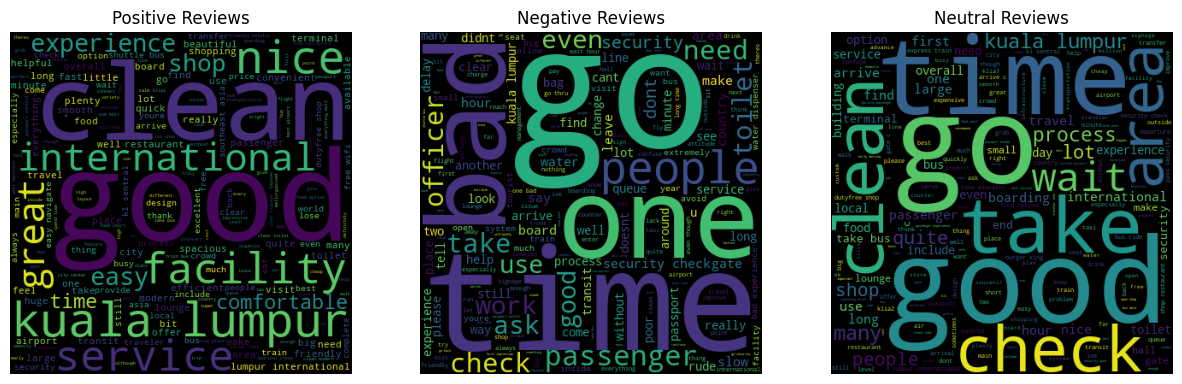

In [10]:
# WordClouds
positive_text = " ".join(df[df.SENTIMENT=="Positive"]['processed_text'])
negative_text = " ".join(df[df.SENTIMENT=="Negative"]['processed_text'])
neutral_text  = " ".join(df[df.SENTIMENT=="Neutral"]['processed_text'])

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title("Positive Reviews")
plt.imshow(WordCloud(width=400, height=400).generate(positive_text))
plt.axis('off')

plt.subplot(1,3,2)
plt.title("Negative Reviews")
plt.imshow(WordCloud(width=400, height=400).generate(negative_text))
plt.axis('off')

plt.subplot(1,3,3)
plt.title("Neutral Reviews")
plt.imshow(WordCloud(width=400, height=400).generate(neutral_text))
plt.axis('off')
plt.show()

In [11]:
# Save cleaned data
df[['processed_text','SENTIMENT']].to_csv("cleaned_training_data.csv", index=False)
print("Saved cleaned_training_data.csv")

Saved cleaned_training_data.csv
